![](../images/rivacon_frontmark_combined_header.png)

# Introduction to Discount Certificates

In [13]:
import datetime as dt
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import pandas as pd
import numpy as np
import rivapy
from rivapy import enums as enums
from rivapy import marketdata as mkt_data


%load_ext autoreload
%autoreload 2
#the next line is a jupyter internal command to show the matplotlib graphs within the notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Definition of a Discount Certificate

Certificate with a reduced entry price in return for a limited payout.
The investor gets the certificate at a price that is below the current price of the underlying security or index. This is called a discount. In return, the potential profit is capped.

At the end of the certificate’s maturity, a cash check occurs: If the price of the underlying when the maturity is up is higher than the maximal payout or identical to it, the issuer pays the maximum amount.

If the price of the underlying is less than the cap, the issuer pays either the current price of the certificate in cash or he gives the investor the underlying, for example a share, at its current price. The issuer can choose. The cash payout is obligatory in the case of discount certificates on indices, currencies or interest.

The maximum profit that an investor can reach with a discount certificate is calculated by taking the difference between the purchase price and the cap on the underlying. Losses, in contrast, are lessened by the discount. The investor suffers a loss only when the price of the underlying at the end of the maturity has fallen so far that the discount is depleted. The discount thus works as a buffer against risk.

Discount certificates are ideal for conservative investors that want to guard against market fluctuations and who expect in the medium term sideways-moving prices. Because the buyer of a discount certificate does not profit from price gains that are higher than the cap, this form of investment is best suited for a medium-term oriented engagement. If the certificate reaches its cap before the maturity, the investor should take the profits.

https://www.boerse-frankfurt.de/en/know-how/glossary/discount-certificates



In [2]:
S0 = 70
St = np.linspace(S0*0.8, S0*1.3, 101)

premium = 5
cap = 77
PnL_DC =  [np.min([S, cap]) - S0 + premium  for S in St]
Payoff_Opt = [premium - np.max([S - cap, 0]) for S in St]

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add trades
fig.add_trace(go.Scatter(x=St,y=St,mode='lines',name='Payoff Underlying',visible = "legendonly"),secondary_y=True,)
fig.add_trace(go.Scatter(x=St,y=[S0 - premium + DC_pnl for DC_pnl in PnL_DC],mode='markers',name='Payoff Certificate',visible = "legendonly"),secondary_y=True)

fig.add_trace(go.Scatter(x=St,y=St - S0,mode='lines',name='PnL Underlying'))
fig.add_trace(go.Scatter(x=St,y=PnL_DC,mode='markers',name='PnL Discount Certificate'))
fig.add_trace(go.Scatter(x=St,y=Payoff_Opt,mode='lines+markers',name='PnL Embedded Short Call'))

fig.add_vline(x=S0,annotation_text='S0',line_dash='dash',line_color='black')
fig.add_vline(x=cap,annotation_text='Cap',line_dash='dash',line_color='black')

# Add figure title
fig.update_layout(title_text='Discount Certificate')

# Set x-axis title
fig.update_xaxes(title_text='Underlying at Maturity')

# Set y-axis titles
fig.update_yaxes(title_text='PnL', secondary_y=False)
fig.update_yaxes(title_text='Payoff', secondary_y=True)

fig.show()

https://www.boerse-stuttgart.de/de-de/produkte/anlageprodukte/discount-zertifikate/stuttgart/dv06rg#Daten-&-Zahlen

---

In [4]:
def B76OptionPricer(Type,F, K, r_dsc, sigma, T, t=0):
    d1 = (math.log(F/K)+(sigma**2/2)*(T-t))/(sigma*math.sqrt(T-t))
    d2 = d1-sigma*math.sqrt(T-t)
    if Type=='c':
        cp = 1
    if Type =='p':
        cp = -1
    return cp*math.exp(-r_dsc*(T-t))*(F*norm.cdf(cp*d1)-K*norm.cdf(cp*d2))

In [5]:
# Definition of the input parameters
#S0 = 90 # Current spot price
K = cap # 50 # Strike price
r_dsc = 0.0 # Discount rate
r_f = 0.0 # Funding rate
r_b = 0.00 # Borrowing rate
sigma = 0.10 # Volatility of the underlying
t = 0.0 # Time to valuation date
T = 1.0 # Time to maturity
F0 = S0*math.exp((r_f-r_b)*(T-t)) # Forward value is calculated assuming a funding-rate different from the discount rate minus the borrowing rate

# Calculation of the call price
c = B76OptionPricer('c', F0, K, r_dsc, sigma, T, t)
print('Call price = ', c)

# #Calculation of the put price
# p = B76OptionPricer('p', F0, K, r_dsc, sigma, T, t)
# print('Put price = ', p)

Call price =  0.6677631743000596


In [6]:
fwd_spots = np.linspace(S0*0.8, S0*1.3, 101)
    
short_call_prices = []
for i in range(len(fwd_spots)):
    short_call_prices.append(B76OptionPricer('c', fwd_spots[i], K, r_dsc, sigma, T, t))

In [7]:
B76OptionPricer('c', 105, K, r_dsc, sigma, T, t)

28.00238696829446

In [8]:
B76OptionPricer('c', 100, 100, r_dsc, sigma, T, 1-1/365) #underlying/fwd + strike

0.20881569492068763

In [9]:
## surface plot:

fwd_spots = np.linspace(S0*0.8, S0*1.3, 101)
ttm = np.linspace(0, 1-1/365, 21)
# ttm[0] = 0.001
    
short_call_prices = []
for i in range(len(fwd_spots)):
    scp_per_mat = []
    for j in range(len(ttm)):
        scp_per_mat.append(B76OptionPricer('c', fwd_spots[i], K, r_dsc, sigma, T, ttm[j]))
    short_call_prices.append(scp_per_mat)


fig_surf = go.Figure(data=[go.Surface(x=ttm, y=fwd_spots,z=short_call_prices
                        ,contours = {"x": {"show": True,"size": 0.1, "color":"red"},
                                    "y": {"show": True,"size": 0.1, "color":"red"},}
                        ,opacity = .75
                        ,hovertemplate =
                        'Underlying:  %{y: .2%}' +\
                        '<br>Maturity (yrs): %{x: .1f}' +\
                        '<br>Payoff: %{z: .2f}<extra></extra>'
                     ,colorscale = 'temps')
                     ])

fig_surf.update_layout(
    title={
        'text': "<b>Volatility Surface</b>",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
    # ,autosize=True
    ,
    width=1000,
    height=1000,
    scene=dict(xaxis_title='Maturity (yrs)',
               xaxis_tickformat='.1f',
               xaxis_autorange='reversed',
               yaxis_title='Strike',
               yaxis_tickformat='.f', #'.2%'
               zaxis_title='Premium',
               zaxis_tickformat='.f'),
    font=dict(family="Courier New, monospace", size=10),
    margin=dict(l=65, r=50, b=65, t=90))

fig_surf.show()

In [10]:
class DiscountCertificatePricingData:
    def __init__(self,
                 val_date: dt,
                 spec,
                 discount_curve,
                 vol_surface,
                 pricing_request
                 ):
        
        self.val_date = val_date
        self.spec = spec
        self.discount_curve = discount_curve
        self.vol_surface = vol_surface
        self.pricing_request = pricing_request
        self.embedded_spec = rivapy.instruments.EuropeanVanillaSpecification(
            id='embeddedOption', type='CALL',
            expiry = self.spec.expiry,
            strike = self.spec.cap,
            issuer = '',
            sec_lvl = 'COLLATERALIZED',
            curr = 'EUR',
            udl_id = '',
            share_ratio = 1.0)
        
def DiscountCertificatePricer(prdata):
    embeddedOption_PricingData = rivapy.pricing.Black76PricingData(val_date = prdata.val_date, 
                                                                    spec = prdata.embedded_spec, 
                                                                    discount_curve = prdata.discount_curve, 
                                                                    vol_surface = prdata.vol_surface,
                                                                    pricing_request=prdata.pricing_request)
    embeddedOptionPrice = rivapy.pricing.price(embeddedOption_PricingData).getPrice()
    return prdata.vol_surface.forward_curve.spot - embeddedOptionPrice
    

    


class DiscountCertificateSpecification:
    def __init__(self, 
                 id: str,
                 expiry: dt,
                 cap: float,
                ):
        
        """Constructor for discount certificates

        Args:

        """
        
        self.id = id
        self.expiry = expiry
        self.cap = cap

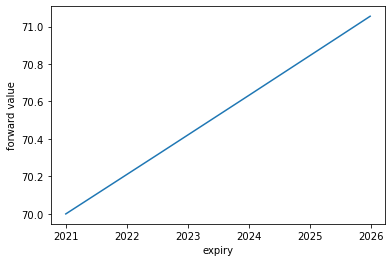

In [14]:
refdate = dt.datetime(2021,1,1,0,0,0)
days_to_maturity = [1, 180, 365, 720, 3*365, 4*365, 10*365]
dates = [refdate + dt.timedelta(days=d) for d in days_to_maturity]
# discount factors from constant rate
disc_rate = 0.005
dc = rivapy.marketdata.DiscountCurve("DC", refdate, dates, 
                                            [math.exp(-d/365.0*disc_rate) for d in days_to_maturity])
borrow_rate = 0.002
bc = rivapy.marketdata.DiscountCurve("BC", refdate, dates, 
                                            [math.exp(-d/365.0*borrow_rate) for d in days_to_maturity])

funding_rate = 0.005
fc = rivapy.marketdata.DiscountCurve("FC", refdate, dates, 
                                            [math.exp(-d/365.0*funding_rate) for d in days_to_maturity])

ex_dates =  [refdate + dt.timedelta(days=i) for i in [365, 2*365, 3*365, 4*365]]
pay_dates = [d + dt.timedelta(days=2) for d in ex_dates]
tax_factors = [1.0, 1.0, 1.0, 1.0]
div_yield = [0, 0.0, 0.0, 0.0]
div_cash = [0, 0, 0, 0]
div_table = rivapy.marketdata.DividendTable('DIV', refdate, ex_dates, pay_dates, div_yield, div_cash, tax_factors)


spot = 70.0
forward_curve = rivapy.marketdata.EquityForwardCurve(spot, fc, bc, div_table)
forward_curve.plot(days_end=5*365)


vol_param_flat = rivapy.marketdata.VolatilityParametrizationFlat(0.3)

ttm = [0.07,0.19,0.69,0.94,1.19,1.69]
fwd_atm_vols =  [0.25,0.24,0.22, 0.21, 0.20, 0.19]
term_param = mkt_data.VolatilityParametrizationTerm(ttm,fwd_atm_vols)

rho = -0.7 # responsible for the skewness of the vol_surface
eta = 0.7 # responsible for the curvature
gamma = 0.6 # responsible for the "rate of decay"
ssvi_param = mkt_data.VolatilityParametrizationSSVI(ttm, fwd_atm_vols, rho, eta, gamma)

svi_param = mkt_data.VolatilityParametrizationSVI(
                expiries=np.array([0.07,0.19,0.69,0.94,1.19,1.69]), 
                svi_params=[
                            (0.01, 0.08, -0.42, 0.07, 0.05),
                            (0.01, 0.09, -0.52, 0.08, 0.05),
                            (0.01, 0.09, -0.72, 0.09, 0.09),
                            (0.02, 0.08, -0.91, 0.10, 0.07),
                            (0.01, 0.12, -0.70, 0.11, 0.19),
                            (0.03, 0.09, -1.02, 0.13, 0.15)
])

ttm = [0.07,0.19,0.69,0.94,1.19,1.69]

sabr_params = np.array([[0.05, 0.90, 0.32, -0.82],
                        [0.08, 0.01, 1.22, -0.49],
                        [0.15, 0.20, 0.12, -0.79],
                        [0.18, 0.84, 0.58, -0.72],
                        [0.20, 0.62, 0.09, -0.58],
                        [0.20, 0.62, 0.09, -0.58]])

vol_surf_flat = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, vol_param_flat)
vol_surf_term = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, term_param)
vol_surf_ssvi = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, ssvi_param)
vol_surf_svi = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, svi_param)
vol_surf_sabr = rivapy.marketdata.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, sabr_params)



In [20]:
myCert_spec = DiscountCertificateSpecification('test_id', dt.datetime(2022,12,31), 77)




prdata_flat = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_flat, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

prdata_term = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_term, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

prdata_ssvi = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_ssvi, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

prdata_svi = DiscountCertificatePricingData(val_date = refdate, 
                                           spec = myCert_spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf_svi, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

# prdata_sabr = DiscountCertificatePricingData(val_date = refdate, 
#                                            spec = myCert_spec, 
#                                            discount_curve = dc, 
#                                            vol_surface = vol_surf_sabr, 
#                                            pricing_request=(rivapy.pricing.ResultType.DELTA, 
#                                                             rivapy.pricing.ResultType.GAMMA))
DiscountCertificatePricer(prdata_svi)

65.87954431361497

In [26]:
## surface plot:

fwd_spots = np.linspace(S0*0.8, S0*1.3, 101)
ttm = np.linspace(0, 1-1/365, 21)
# ttm[0] = 0.001
    
dc_prices = []
for i in range(len(fwd_spots)):
    scp_per_mat = []
    for j in range(len(ttm)):
        scp_per_mat.append(B76OptionPricer('c', fwd_spots[i], K, r_dsc, ssvi_param.calc_implied_vol(ttm[j],1.1), T, ttm[j]))
    dc_prices.append(fwd_spots[i]-scp_per_mat)


fig_surf = go.Figure(data=[go.Surface(x=ttm, y=fwd_spots,z=dc_prices
                        ,contours = {"x": {"show": True,"size": 0.1, "color":"red"},
                                    "y": {"show": True,"size": 0.1, "color":"red"},}
                        ,opacity = .75
                        ,hovertemplate =
                        'Underlying:  %{y: .2%}' +\
                        '<br>Maturity (yrs): %{x: .1f}' +\
                        '<br>Payoff: %{z: .2f}<extra></extra>'
                     ,colorscale = 'temps')
                     ])

fig_surf.update_layout(
    title={
        'text': "<b>Volatility Surface</b>",
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
    # ,autosize=True
    ,
    width=1000,
    height=1000,
    scene=dict(xaxis_title='Maturity (yrs)',
               xaxis_tickformat='.1f',
               xaxis_autorange='reversed',
               yaxis_title='Strike',
               yaxis_tickformat='.f', #'.2%'
               zaxis_title='Premium',
               zaxis_tickformat='.f'),
    font=dict(family="Courier New, monospace", size=10),
    margin=dict(l=65, r=50, b=65, t=90))

fig_surf.show()

In [24]:
ssvi_param.calc_implied_vol(.5,77)

0.4623666480975142